# Vehicle Detection Project

The steps of this project are the following:
1. Train a Linear SVM classifier to recognize cars, based on a Histogram of Oriented gradients (HOG) feature extraction,
2. Implement a sliding-window to search for vehicles in images, with the classifier trained previously,
3. Run the pipeline on the project video stream and create a heat map, to reject outliers and follow detected vehicles,
4. Estimate a bounding box for vehicles detected

In [1]:
# Import all required libraries
import os
import glob
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.externals import joblib
from skimage.feature import hog

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

from IPython.display import HTML

def _build_full_paths(dir_root):
    return [os.path.join(dir_root, fn) for fn in os.listdir(dir_root)]

%matplotlib inline

## 1. Train a linear SVM classifier to recognize cars

### a. Load labeled data

All images ...
Number of 'car' images: 8792
Number of 'not car' images: 8968


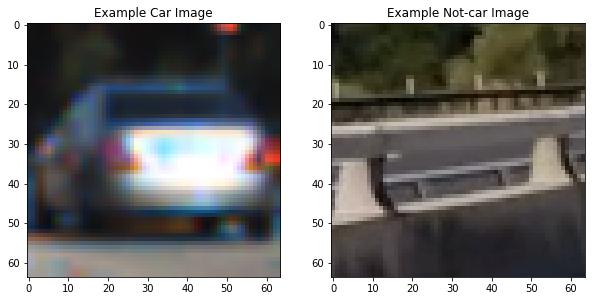

In [2]:
def display_random_images(cars, not_cars):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(not_cars))

    img_reader, img_params = cars[car_ind]
    car_image = img_reader(img_params)

    img_reader, img_params = not_cars[notcar_ind]
    notcar_image = img_reader(img_params)

    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

    
def load_labeled_images(cars=[], not_cars=[]):
    def img_reader(img_path):
        return mpimg.imread(img_path)
        
    images = glob.glob('data/*/*/*/*.png')
    for image in images:
        if 'non-vehicles' in image:
            not_cars.append( (img_reader, image) )
        else:
            cars.append( (img_reader, image) )
    
    return cars, not_cars


def load_annoted_driving_dataset1(cars=[], not_cars=[]):
    source_dir = ['data','object-detection-crowdai']
    def img_reader(img_params):
        xmin, ymin, xmax, ymax, Frame = img_params
        img = mpimg.imread(os.path.join(*source_dir, Frame))
        return img[ymin:ymax, xmin:xmax] #cv2.resize(img[ymin:ymax, xmin:xmax], (64,64))
    
    discarded = 0
    with open(os.path.join(*source_dir, 'labels.csv'), newline='') as f:
        reader = csv.DictReader(f, delimiter=',', quoting=csv.QUOTE_NONE)
        for row in reader:
            xmin, ymin, xmax, ymax, Frame, Label = row['xmin'], row['xmax'], row['ymin'], row['ymax'], row['Frame'], row['Label']
            xmin, ymin, xmax, ymax = tuple(map(int, (xmin, ymin, xmax, ymax)))
            
            if xmin >= xmax or ymin >= ymax:
                discarded += 1
                continue
            
            if Label.lower() == 'car':
                cars.append( (img_reader, (xmin, ymin, xmax, ymax, Frame)) )
            else:
                not_cars.append( (img_reader, (xmin, ymin, xmax, ymax, Frame)) )
    
    print("In object-detection-crowdai: ", discarded, " discarded")
    return cars, not_cars


def load_annoted_driving_dataset2(cars=[], not_cars=[]):
    source_dir = ['data','object-dataset']
    def img_reader(img_params):
        xmin, xmax, ymin, ymax, Frame = img_params
        img = mpimg.imread(os.path.join(*source_dir, Frame))
        return cv2.resize(img[ymin:ymax, xmin:xmax], (64,64))
    
    discarded = 0
    with open(os.path.join(*source_dir, 'labels.csv'), newline='') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_MINIMAL)
        # frame xmin ymin xmax ymax occluded label attributes(Only appears on traffic lights)
        for row in reader:
            frame, xmin, ymin, xmax, ymax, occluded, label = row[0], row[1], row[2], row[3], row[4], row[5], row[6]
            xmin, xmax, ymin, ymax = tuple(map(int, (xmin, xmax, ymin, ymax)))
            
            if xmin >= xmax or ymin >= ymax:
                discarded += 1
                continue
            
            if label.lower() == 'car':
                cars.append( (img_reader, (xmin, xmax, ymin, ymax, frame)) )
            else:
                not_cars.append( (img_reader, (xmin, xmax, ymin, ymax, frame)) )
    
    print("In object-dataset: ", discarded, " discarded")
    return cars, not_cars

cars, not_cars = load_labeled_images()
# cars, not_cars = load_annoted_driving_dataset1()
# load_annoted_driving_dataset2(cars, not_cars)

print('All images ...')
print('Number of \'car\' images:', len(cars))
print('Number of \'not car\' images:', len(not_cars))

display_random_images(cars, not_cars)

### b. Train a Linear SVM classifier

#### i. Extract HOG features

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=True):
    if visualise == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), 
                                  block_norm='L2-Hys', transform_sqrt=True, 
                                  visualise=visualise, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm='L2-Hys', transform_sqrt=True, 
                       visualise=visualise, feature_vector=feature_vec)
        return features

# This function compute the HOG on the whole image.
def cvt_color(img, cspace='YCrCb'):
    color_cvt = {
        'HSV': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HSV),
        'LUV': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2LUV),
        'HLS': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2HLS),
        'YUV': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YUV),
        'YCrCb': lambda img: cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb),
    }
    return color_cvt[cspace](img)

def extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec=True):
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(image.shape[2]):
            hog_features.append(get_hog_features(image[:,:,channel], orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=feature_vec))
            
        if feature_vec:
            hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, visualise=False, feature_vec=feature_vec)

    return hog_features
        


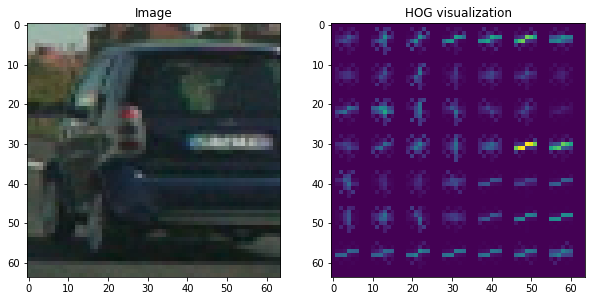

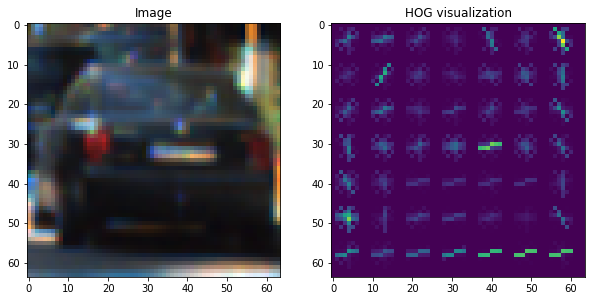

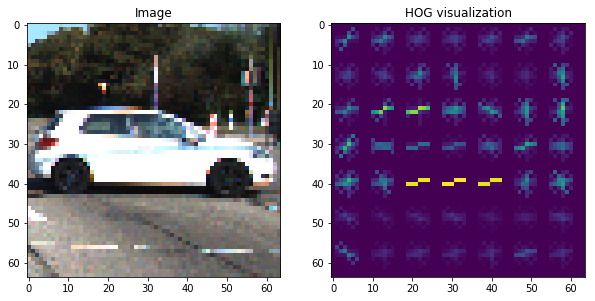

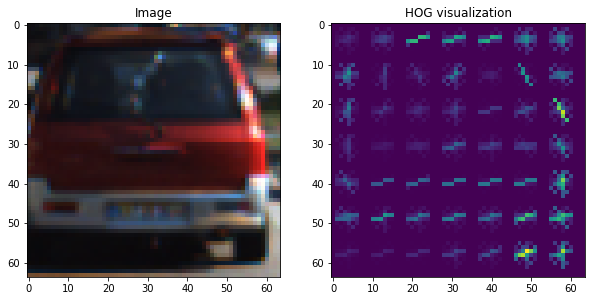

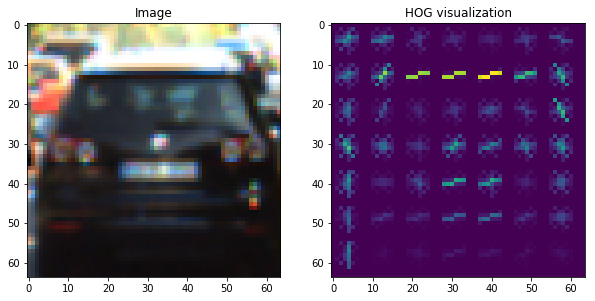

In [4]:
# Show examples of HOG images
def display_HOG_random_images(cars__not_cars, nb):
    for n in range(nb):
        idx = np.random.randint(0, len(cars__not_cars))
        img_reader, img_params = cars__not_cars[idx]
        
        image = img_reader(img_params)
    
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
        features, hog_image = get_hog_features(gray, orient=9, pix_per_cell=9, cell_per_block=4, visualise=True)
        fig = plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(image)
        plt.title('Image')
        plt.subplot(122)
        plt.imshow(hog_image)
        plt.title('HOG visualization')

display_HOG_random_images(cars, 5)


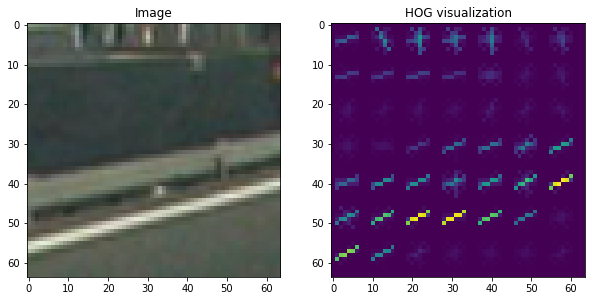

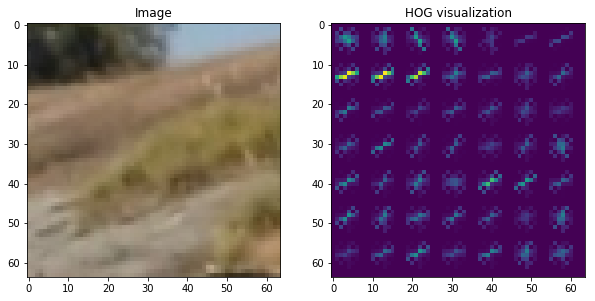

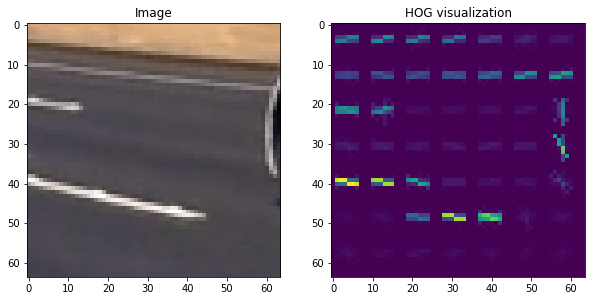

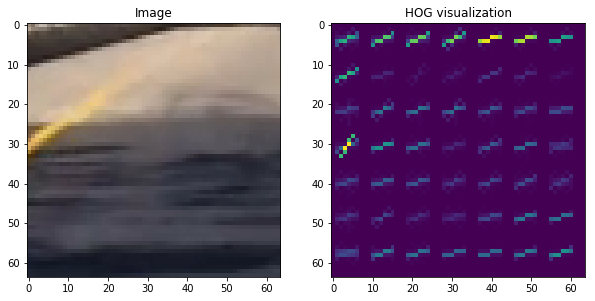

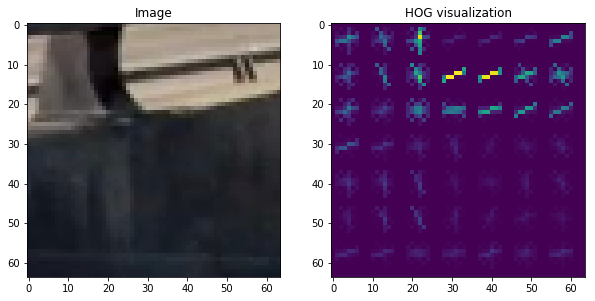

In [5]:
display_HOG_random_images(not_cars, 5)

#### ii. Extract color features

In [6]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

#### iii. Train a Linear SVM classifier    

In [7]:
def extract_features_per_image(image, 
                               cspace, spatial_size, hist_bins, 
                               orient, pix_per_cell, cell_per_block, hog_channel, feature_vec,
                               resize=(64,64)):
    if cspace != 'RGB':
        image = cvt_color(image, cspace)
    
    hog_features = extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec)
        
    image_shape = image.shape
    if image_shape[0] != resize[0] or image_shape[1] != resize[1]:
        resized = cv2.resize(image, resize)
    else:
        resized = image
        
    # Get color features
    spatial_features = bin_spatial(resized, size=spatial_size)
    hist_features = color_hist(resized, nbins=hist_bins)
        
    return np.hstack((spatial_features, hist_features, hog_features))


def extract_HOG_features_per_image(image, 
                                   cspace, spatial_size, hist_bins, 
                                   orient, pix_per_cell, cell_per_block, hog_channel, feature_vec,
                                   resize=(64,64)):
    if cspace != 'RGB':
        image = cvt_color(image, cspace)
    
    hog_features = extract_hog_features(image, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec)
    return hog_features

    
def extract_features(imgs, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec,
                        extract_features_per_image_fct=extract_features_per_image):
    features = []
    for img_reader, img_params in imgs:
        image = img_reader(img_params)
        features.append( extract_features_per_image_fct(image, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec) )
    
        # Add Flipped image
        flip_image = cv2.flip(image, 1)
        features.append( extract_features_per_image_fct(flip_image, cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, feature_vec) )
        
    return features


def find_best_parameters(scaled_X, y):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(scaled_X, y)
    print(clf.best_params_)

    
def build_scaled_dataset(cars, notcars, 
                         cspace='YCrCb', spatial_size=(32, 32), hist_bins=32, 
                         orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel="ALL", feature_vec=True,
                            extract_features_per_image_fct=extract_features_per_image):
    # HOG features
    car_features = extract_features(cars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, feature_vec=feature_vec, extract_features_per_image_fct=extract_features_per_image_fct)
    notcar_features = extract_features(notcars, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, feature_vec=feature_vec, extract_features_per_image_fct=extract_features_per_image_fct)
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)   
    
    # Scaled the dataset
    # X_scaler = StandardScaler().fit(X)
    X_scaler = RobustScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    # Build the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return scaled_X, y, X_scaler


def train_dataset(clf, scaled_X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=test_size, random_state=np.random.randint(0, 100))
    clf.fit(X_train, y_train)
    print("Shape X_train: ", X_train.shape, " - Shape y: ", y_train.shape)
    return round(clf.score(X_test, y_test), 4)

In [8]:
# HOG + color features

%time scaled_X, y, X_scaler = build_scaled_dataset(cars, not_cars, cspace='YCrCb', orient=9, pix_per_cell = 8, cell_per_block = 4)

svc = svm.LinearSVC()
%time test_accuracy = train_dataset(svc, scaled_X, y)

print('Test accuracy (HOG + color features): ', test_accuracy)

Wall time: 3min 24s
Shape X_train:  (28416, 13968)  - Shape y:  (28416,)
Wall time: 45.4 s
Test accuracy (HOG + color features):  0.9865


In [9]:
# Save the model

#joblib.dump(svc, 'classier_std.pkl') 
#joblib.dump(svc, 'scaler_std.pkl') 

In [10]:
# Pure HOG classifier

#%time scaled_X, y, X_HOG_scaler = build_scaled_dataset(cars, not_cars, cspace='YCrCb', orient=9, pix_per_cell = 8, cell_per_block = 4, extract_features_per_image_fct=extract_HOG_features_per_image)

#hog_svc = svm.LinearSVC()

#%time test_accuracy = train_dataset(hog_svc, scaled_X, y)

#print('Test accuracy (HOG features only: ', test_accuracy)

## 2. Sliding window to search for vehicles 

In [11]:
# svc = joblib.load('classier_std.pkl') 
# X_scaler = joblib.load('scaler_std.pkl') 

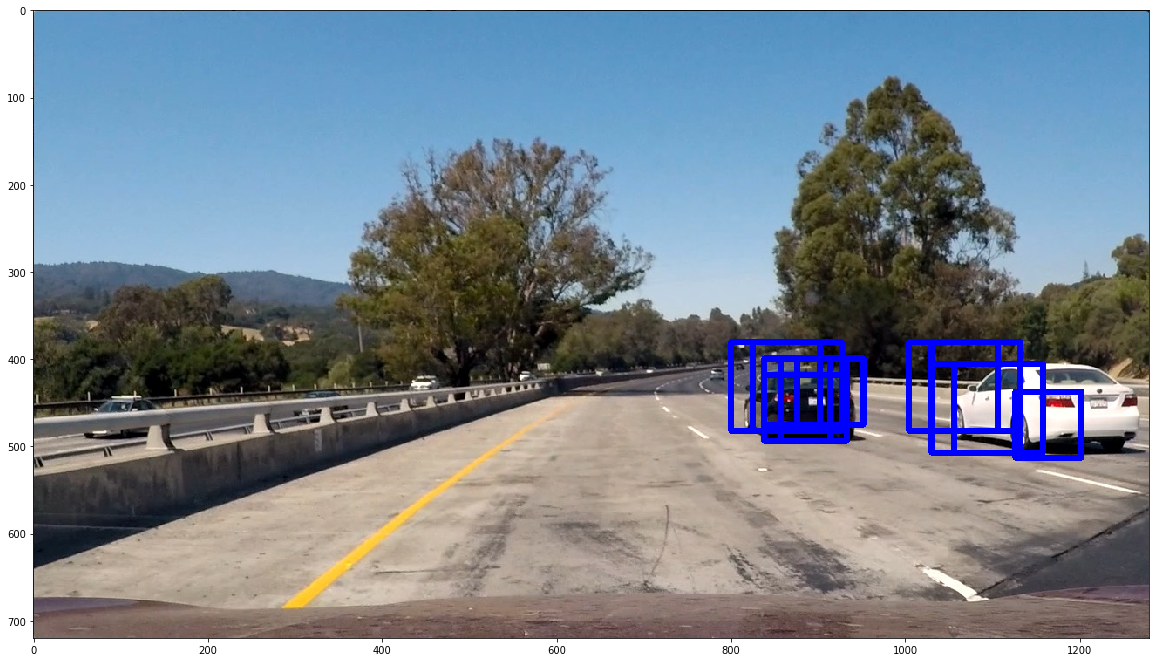

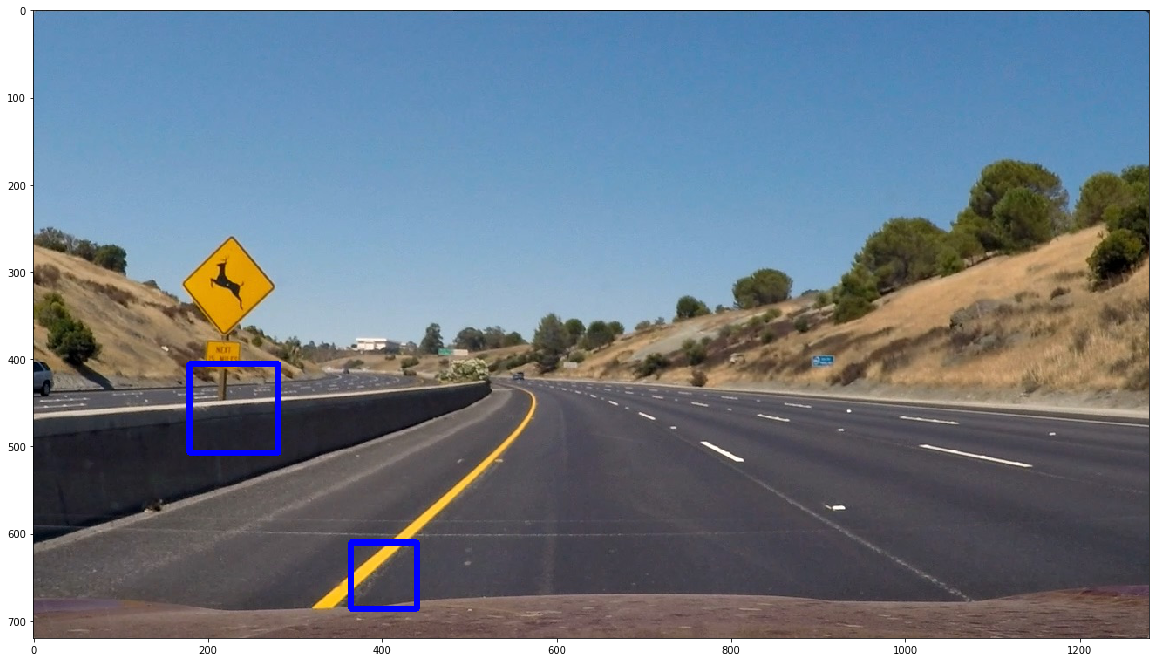

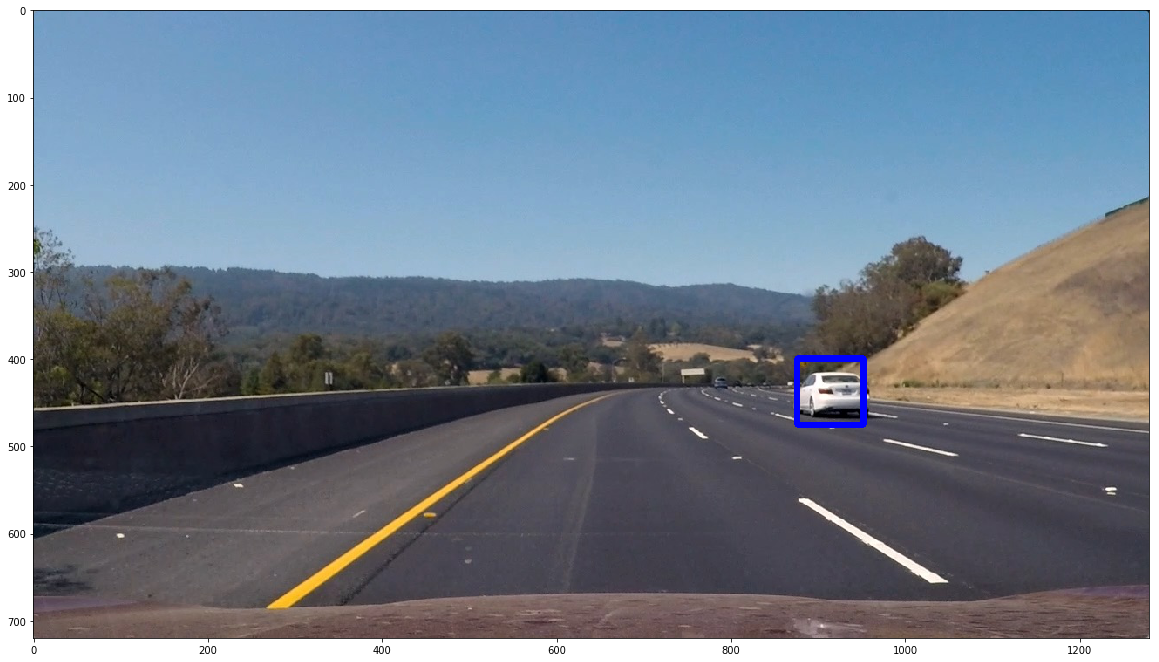

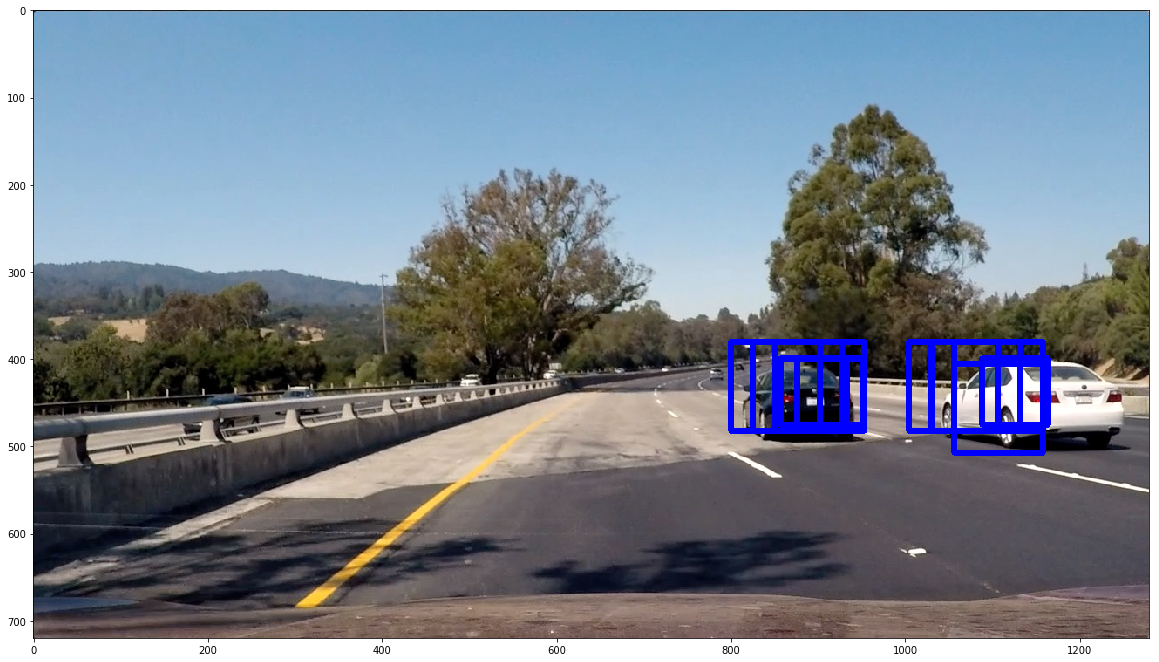

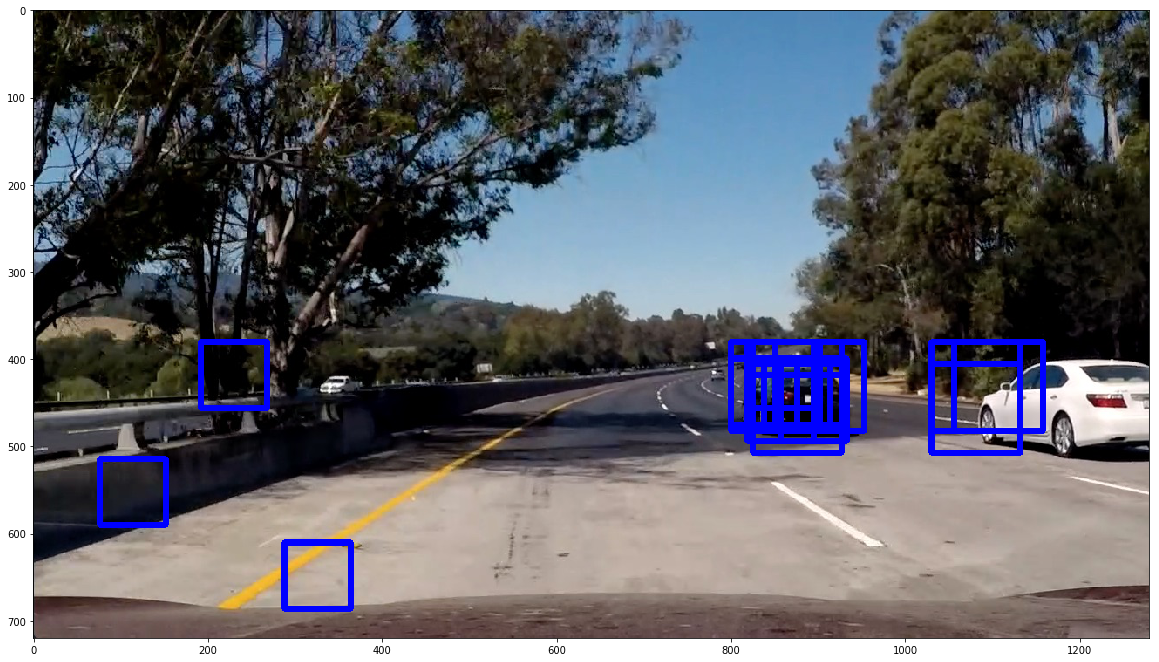

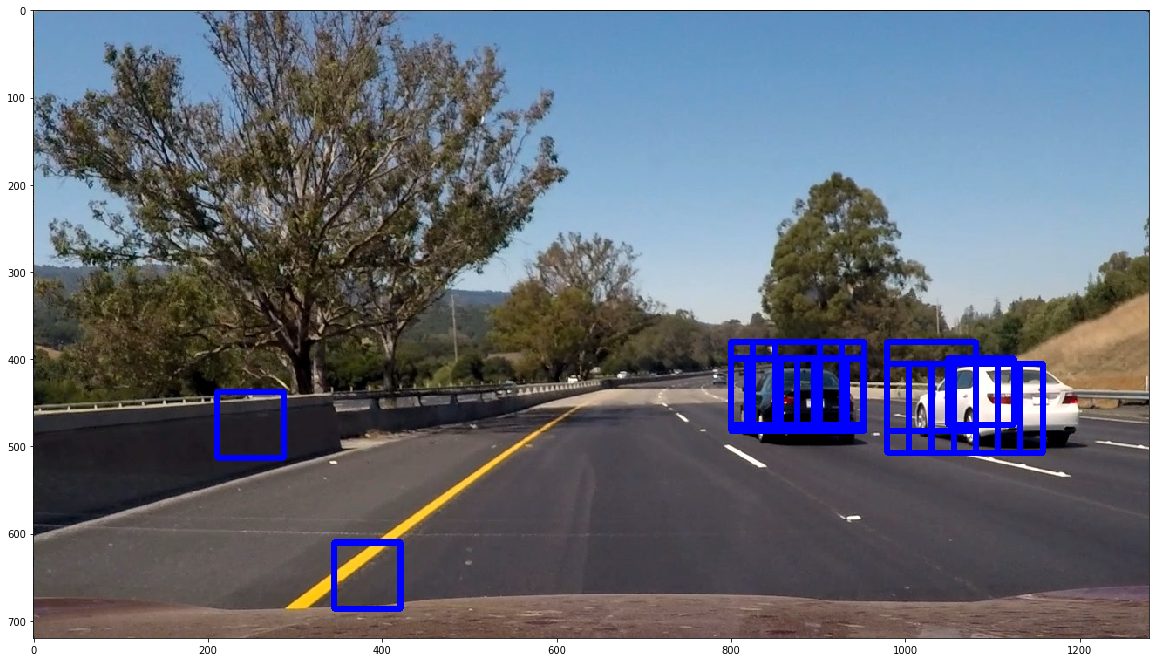

In [51]:
# Algo to find cars:
def image_feeder(img, scales, search_boxes, cspace):
    img = img.astype(np.float32)/255
    
    result = []
    
    if search_boxes is None:
        search_boxes = (None,)
    
    for box in search_boxes:
        if box is None:
            xmin, xmax, ymin, ymax = 0, img.shape[1], 0, img.shape[0]
        else:
            xmin, xmax, ymin, ymax = box
            if xmin is None:
                xmin = 0
            if xmax is None:
                xmax = img.shape[1]
            if ymin is None:
                ymin = 0
            if ymax is None:
                ymax = img.shape[0]
    
        img_tosearch = img[ymin:ymax,xmin:xmax,:]
        ctrans_tosearch = cvt_color(img_tosearch, cspace=cspace)
    
        for scale in scales:
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(ctrans_tosearch.shape[1]/scale), int(ctrans_tosearch.shape[0]/scale)))
            #plt.imshow(ctrans_tosearch)
            #plt.figure()
            
            result.append( (ctrans_tosearch, scale, xmin, ymin) )
    return result


def find_cars_in_image(ctrans_tosearch, scale, xstart, ystart, svc, X_scaler, 
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_window=8, cells_per_step = 2):
    bboxes = None
        
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    if nxblocks <= 0 or nyblocks <= 0:
        return None
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = cells_per_window * pix_per_cell
    nblocks_per_window = ((window // pix_per_cell) - cell_per_block) + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute HOG features for the entire image
    hogs = extract_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, hog_channel="ALL", feature_vec=False)
    
    for yb in range(nysteps):
        for xb in range(nxsteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hogs_per_ch = [hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() for hog in hogs]
            hog_features = np.hstack(hogs_per_ch)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            decision = svc.decision_function(test_features)[0]
            test_prediction = int( decision > 0.75 )
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = np.array([xbox_left+xstart, ytop_draw+ystart, xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart, int(decision*100.)])
                if bboxes is None:
                    bboxes = np.vstack((box,))
                else:
                    bboxes = np.vstack((bboxes, box))
                
    return bboxes


def find_cars(img, scales, search_boxes):
    # boxes = []
    boxes = None
    for image, scale, x_start, y_start in image_feeder(img, scales, search_boxes=search_boxes, cspace='YCrCb'):
        bboxes = find_cars_in_image(image, scale, x_start, y_start, svc, X_scaler,
                                    orient = 9, pix_per_cell = 8, cell_per_block = 4, spatial_size=(32,32), hist_bins=32,
                                    cells_per_window=8)
        
        if bboxes is not None:
            if boxes is None:
                boxes = np.vstack((bboxes,))
            else:
                boxes = np.vstack((boxes, bboxes))

    return boxes

def draw_boxes(img, scales, search_boxes=((0, 500, 380, 710), (500, 800, 360, 500), (800, 1280, 380, 710)) ):
    draw_img = np.copy(img)
    
    boxes = find_cars(draw_img, scales, search_boxes)
    
    if boxes is None:
        return draw_img
    
    # boxes = non_max_suppression_fast(boxes, 0.05)
    
    for box in boxes:
        x1, y1, x2, y2, decision = box
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), (0,0,255), 6)
    
    return draw_img
        
scales = [1.2, 1.6, 1.9]
    
for file in _build_full_paths('test_images'):
    img = mpimg.imread(file)
    draw_img = draw_boxes(img, scales)
    plt.figure(figsize=(20,20))
    plt.imshow(draw_img)
    plt.figure()
    

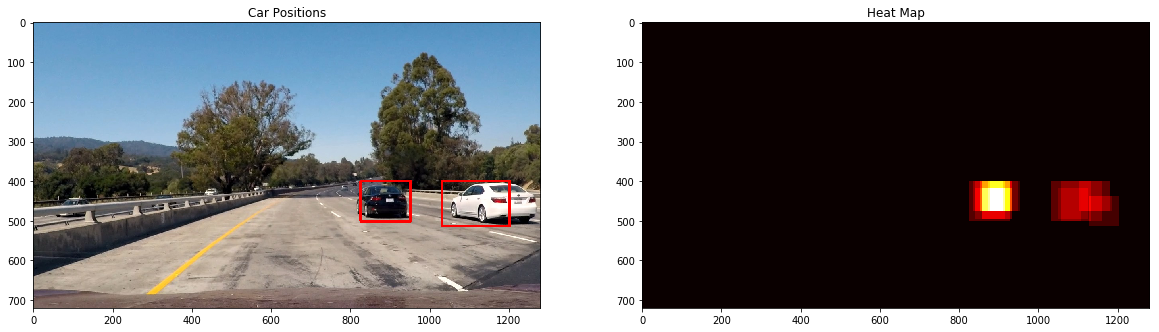

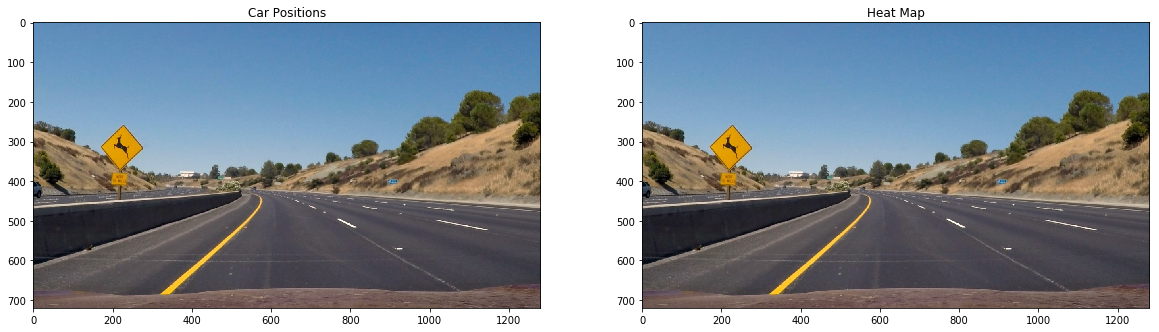

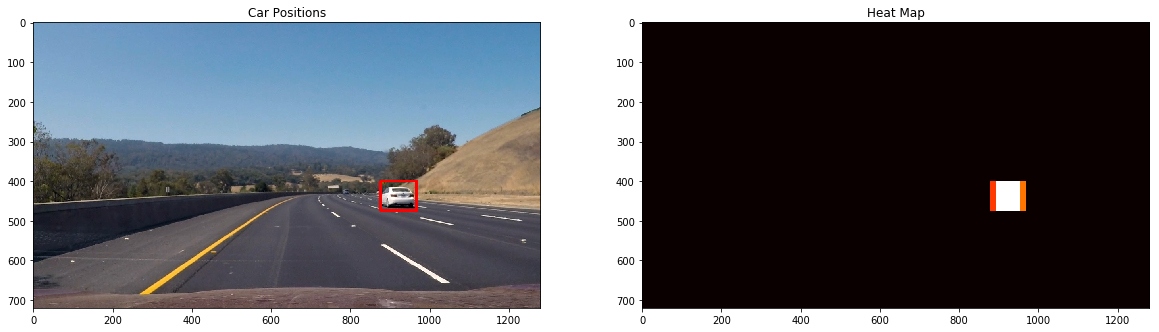

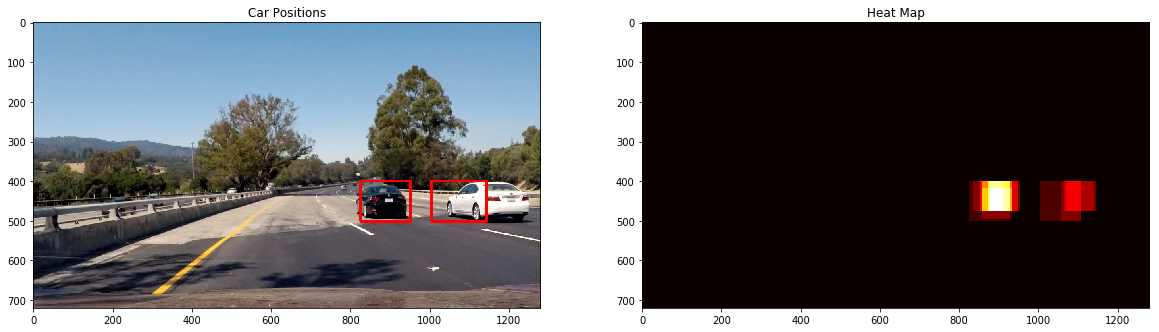

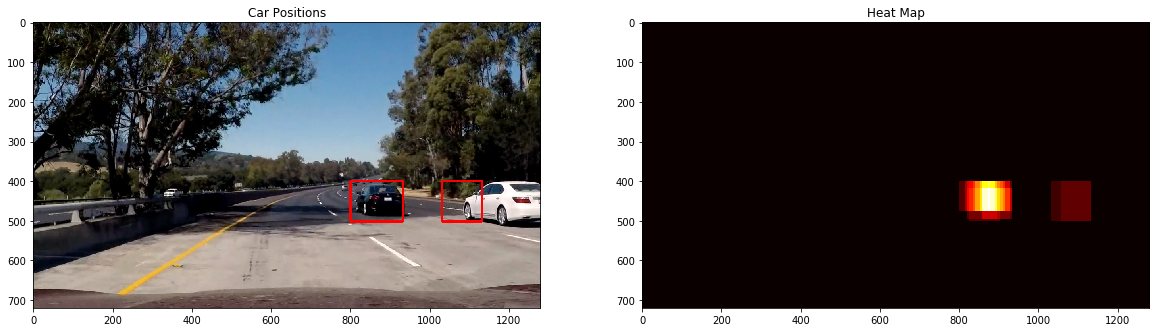

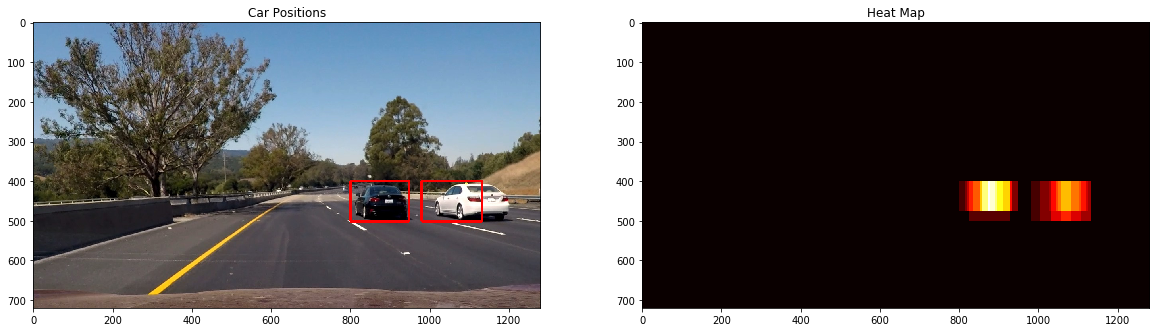

In [62]:
# ((0, 500, 500, 680), (200, 1200, 400, 500), (700, None, 380, 680))
def draw_heatmap(img, scales, previous_boxes_stack, search_boxes=((0, 500, 500, 680), (200, 1200, 400, 500), (800, None, 400, 680)), with_heatmap=False):
    def add_heat(heatmap, boxes, previous_boxes_stack):
        
        if len(previous_boxes_stack) != 0:
            for previous_boxes in previous_boxes_stack:
                boxes = np.vstack((boxes, previous_boxes))
        
        for box in boxes:
            x1, y1, x2, y2, decision = box
            heatmap[y1:y2, x1:x2] += decision

        return heatmap
    
    def apply_threshold(heatmap, threshold):
        heatmap[heatmap <= threshold] = 0
        return heatmap
    
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
        # Return the image
        return img
    
    boxes = find_cars(img, scales, search_boxes)
    
    if boxes is None:
        if with_heatmap:
            return img, img
        else:
            return img
        
    # boxes = non_max_suppression_fast(boxes, 0.05)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, boxes, previous_boxes_stack)
    
    # Apply threshold to help remove false positives
    # heat = apply_threshold(heat, 2)
    #print(np.max(heat))
    #heat = apply_threshold(heat, 100)
    heat_std = heat.std(ddof=1)
    if heat_std != 0.0:
        heat = (heat-heat.mean())/heat_std
    heat = apply_threshold(heat, np.max([heat.std(), 1]))    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Maintain the previous boxes list
    previous_boxes_stack.append(boxes)
    
    while len(previous_boxes_stack) >= 5:
        previous_boxes_stack.pop(0)
    
    if with_heatmap:
        return draw_img, heatmap
    else:
        return draw_img

def show_img_heatmap(img, heatmap):
    fig = plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')

for file in _build_full_paths('test_images'):
    img = mpimg.imread(file)
    previous_boxes_stack = []
    heat_img, heatmap = draw_heatmap(img, scales, previous_boxes_stack, with_heatmap=True)
    show_img_heatmap(heat_img, heatmap)

## 3. Apply vehicle detection pipeline to videos

In [14]:
def process_save_video(project_input, project_output, process_img_fct):
    clip1 = VideoFileClip(project_input)
    project_clip = clip1.fl_image(process_img_fct) 

    %time project_clip.write_videofile(project_output, audio=False)

In [63]:
# I created a class here just to encapsulate the _previous_boxes_stack list
# and to be sure this list is freshly created when I re-run the cell 
# (creation of the object instance of VehicleDetector())
class VehicleDetector:
    def __init__(self):
        self._previous_boxes_stack = []

    def process_pipeline(self, img):
        return draw_heatmap(img, scales, self._previous_boxes_stack)

vehicle_detector = VehicleDetector()
process_save_video('project_video.mp4', 'project.mp4', vehicle_detector.process_pipeline)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [11:55<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 

Wall time: 11min 55s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project.mp4"))